# Annotated directions analysis

In [1]:
import json
import numpy as np
import os
import pandas as pd
import requests

import matplotlib.pyplot as plt
%matplotlib inline

## 1 &emsp; Preparation

Gathering paths to plays' `.csv` files and their IDs (which are basically author's name and play title):

In [10]:
# if you're doing this for the first time — run everything until Part 3
path_to_annot = "./data/stage/annotated/"
plays_csv = [play_id for play_id in os.listdir(path_to_annot) if play_id != ".DS_Store"]
play_paths = [path_to_annot + play_id for play_id in plays_csv]
play_ids = [play_csv[:-4] for play_csv in plays_csv]

### 1.1 &emsp; Data not present in .csv

Additional functions: adding year of the play and `play_id`:

Extracting **year of the play**, fetched from corpus metadata:

In [11]:
request_link = "https://dracor.org/api/corpora/rus/metadata"
response = requests.get(request_link)
if response.status_code == 200:
    play_metadata = response.json()

In [12]:
def append_play_year(play_id, play_metadata):
    """Using metadata from DraCor API, extracts yearNormalized
    for the play.
    
    Calculation of yearNormalized:
    > if date_print and date_premiere:
    >     yearNormalized = min(date_print, date_premiere)
    > elif date_premiere:
    >     yearNormalized = date_premiere
    > else:
    >     yearNormalized = date_print
    > if date_written and yearNormalized:
    >     if yearNormalized - date_written > 10:
    >         yearNormalized = date_written
    >     elif date_written and not yearNormalized:
    >         yearNormalized = date_written
    
    :args play_id (str) — author's name and title of the play
    play_metadata (json) — metadata for all the plays currently
    present in the corpus
    
    :returns year (int) — normalized year of the play
    """
    
    for play in play_metadata:
        if play["playName"] == play_id:
            year = int(play["yearNormalized"])
            break
        else:
            year = 0
    if year == 0:
        print("Couldn't retrieve year.\n\t- play: {}\n\t- status code: {} \
            \n=> Returning 0".format(play_id, response.status_code))
    return year

## 2 &emsp; Assembling everything together

In [13]:
def csv_to_full_df(play_id):
    """Converts .csv files for /data/stage/annotated into a 
    pd.DataFrame, then adds 
        (1) directions' origin, 
        (2) normalized year of the play (see append_play_year()).
            
    :args play_id (str) — author's name and title of the play
    
    :returns play_df (pd.DataFrame) — converted data of a single play
    """
    
    play_csv_path = "./data/stage/annotated/{}.csv".format(play_id)
    play_df = pd.read_csv(play_csv_path, sep=";", encoding="utf-8").fillna(0)
    
    # convert direction marks to categories
    for dir_type in play_df.columns[1:]:
        play_df[dir_type] = play_df[dir_type].astype("category")
    
    # add play_id so that we know directions' origin
    add_play_name = lambda play_id : play_id
    play_df["play"] = [add_play_name(play_id)] * len(play_df)
    
    # add yearNormalized
    play_df["year"] = [append_play_year(play_id, play_metadata)] * len(play_df)
    
    return play_df

Concatenating all plays in a single dataset:

In [14]:
df_total = pd.DataFrame(columns=["text", "setting", "entrance", "exit", "business", "delivery", 
                                 "modifier", "location", "unknown", "play", "year"])

In [15]:
for play_id in play_ids:
    play_df = csv_to_full_df(play_id)
    df_total = pd.concat([df_total, play_df], ignore_index=True)

Sanity checks:

In [16]:
# dataframe columns
df_total.head()

,text,setting,entrance,exit,business,delivery,modifier,location,unknown,play,year
0,"Игроки, князь Звездич, Казарин и Шприх. За сто...",1,0,0,1,0,0,0,0,lermontov-maskarad,1842
1,(тихо первому),0,0,0,0,1,0,0,0,lermontov-maskarad,1842
2,(насмешливо),0,0,0,0,1,0,0,0,lermontov-maskarad,1842
3,"(сквозь зубы, уходя)",0,0,1,0,1,0,0,0,lermontov-maskarad,1842
4,"Князь, выпив стакан лимонаду, садится к сторон...",0,0,0,1,0,0,0,0,lermontov-maskarad,1842


In [17]:
# amount of directions
df_total[df_total["play"] == "lermontov-maskarad"]["text"].count()

401

In [18]:
len(df_total)

6541

In [19]:
df_total["play"]

turgenev-holostjak          686
chekhov-tri-sestry          653
chekhov-vishnevyi-sad       575
ostrovsky-les               486
chekhov-chaika              474
gogol-revizor               433
chekhov-djadja-vanja        412
lermontov-maskarad          401
ostrovsky-bespridannitsa    395
tolstoy-zhivoy-trup         371
fonvizin-nedorosl           349
tolstoy-tsar-boris          258
gogol-zhenitba              254
ostrovsky-svoi-ljudi        234
griboyedov-gore-ot-uma      209
pushkin-boris-godunov       172
krylov-urok-dochkam         146
sumarokov-horev              33
Name: play, dtype: int64

## 3 &emsp; Saving

This data is raw — we haven't done any analysis yet. Nevertheless, it might be useful to save it for later research.

In [20]:
# run to_csv if this is the first time you're running the notebook
df_total.to_csv("./data/csv/annot_merged_raw.csv", sep=";", encoding="utf-8", index=False)
# otherwise run read_csv
# df_total = pd.read_csv("./data/csv/annot_merged_raw.csv", sep=";", encoding="utf-8")
# df_total.head()

## 4 &emsp; Directions distribution among plays

### 4.1 &emsp; How many directions are there in the plays year-wise?

In [73]:
direction_types = ["setting", "entrance", "exit", "business", "delivery", 
                   "modifier", "location", "unknown"]
plays = df_total["play"].unique()

dir_amount = []
years = []

dict_plays = {}
for play in plays:
    year = df_total[df_total["play"] == play]["year"].unique()[0]
    amount = df_total[df_total["play"] == play]["text"].count()
    dict_plays[play] = [amount, year]

In [80]:
def match_play_to_directions(play, play_dict):
    return play_dict[play][0]

In [90]:
def match_play_to_year(year, play_dict, ready_plays):
    for play in play_dict:
        if year == play_dict[play][1] and play not in ready_plays:
            ready_plays.append(play)
            return play

In [91]:
ready_plays = []
[match_play_to_year(year, dict_plays, ready_plays) for year in [1842, 1842]]

['lermontov-maskarad', 'gogol-zhenitba']

In [82]:
match_play_to_directions("gogol-zhenitba", dict_plays)

254

In [93]:
ready_plays = []

years_sorted = sorted([value[1] for value in dict_plays.values()])
plays_sorted = [match_play_to_year(year, dict_plays, ready_plays) for year in years_sorted]
directions_amounts = [dict_plays[play][0] for play in plays_sorted]

for i in range(len(years_sorted)):
    print("{} was written in {} with {} directions".format(plays_sorted[i], years_sorted[i],
                                                      directions_amounts[i]))

sumarokov-horev was written in 1747 with 33 directions
fonvizin-nedorosl was written in 1782 with 349 directions
krylov-urok-dochkam was written in 1807 with 146 directions
griboyedov-gore-ot-uma was written in 1825 with 209 directions
pushkin-boris-godunov was written in 1831 with 172 directions
gogol-revizor was written in 1836 with 433 directions
lermontov-maskarad was written in 1842 with 401 directions
gogol-zhenitba was written in 1842 with 254 directions
turgenev-holostjak was written in 1849 with 686 directions
ostrovsky-svoi-ljudi was written in 1850 with 234 directions
tolstoy-tsar-boris was written in 1870 with 258 directions
ostrovsky-les was written in 1871 with 486 directions
ostrovsky-bespridannitsa was written in 1878 with 395 directions
chekhov-chaika was written in 1896 with 474 directions
chekhov-djadja-vanja was written in 1897 with 412 directions
tolstoy-zhivoy-trup was written in 1900 with 371 directions
chekhov-tri-sestry was written in 1901 with 653 directions
c

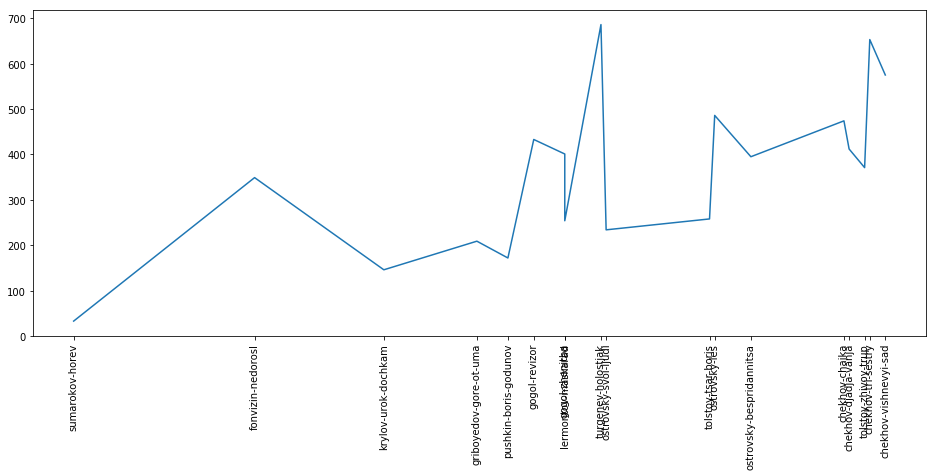

In [94]:
plt.figure(figsize=(16,6))
plt.xticks(years_sorted, labels=plays_sorted, rotation=90)
dict_plays_sorted = sorted(dict_plays)
plt.plot(years_sorted, directions_amounts)

### 4.2 &emsp; What are the proportions of different types in the plays?

First, we have to gather the data, i.e. to sum up all the types for a certain play.

In [95]:
types_dict = {
    dir_type: [] for dir_type in direction_types + ["play", "year"]
}
for play in plays:
    types_dict["play"].append(play)
    types_dict["year"].append(dict_plays[play][1])
    types_values = df_total[df_total["play"] == play].sum()[direction_types]
    for ty in types_values.keys():
        types_dict[ty].append(types_values[ty])

In [96]:
df_types = pd.DataFrame.from_dict(types_dict).set_index("play")
df_types.head()

,setting,entrance,exit,business,delivery,modifier,location,unknown,year
play,,,,,,,,,
lermontov-maskarad,8.0,66.0,44.0,212.0,93.0,0.0,2.0,4.0,1842
krylov-urok-dochkam,0.0,21.0,11.0,73.0,45.0,0.0,2.0,1.0,1807
tolstoy-tsar-boris,5.0,68.0,44.0,152.0,34.0,0.0,15.0,1.0,1870
griboyedov-gore-ot-uma,3.0,39.0,29.0,83.0,61.0,0.0,9.0,0.0,1825
chekhov-tri-sestry,5.0,57.0,51.0,459.0,104.0,8.0,35.0,4.0,1901


In [97]:
df_types = df_types.sort_values(by=["year"])
df_types.head()

,setting,entrance,exit,business,delivery,modifier,location,unknown,year
play,,,,,,,,,
sumarokov-horev,0.0,26.0,1.0,4.0,1.0,0.0,0.0,1.0,1747
fonvizin-nedorosl,0.0,46.0,22.0,151.0,133.0,9.0,3.0,5.0,1782
krylov-urok-dochkam,0.0,21.0,11.0,73.0,45.0,0.0,2.0,1.0,1807
griboyedov-gore-ot-uma,3.0,39.0,29.0,83.0,61.0,0.0,9.0,0.0,1825
pushkin-boris-godunov,9.0,37.0,22.0,89.0,23.0,0.0,6.0,1.0,1831


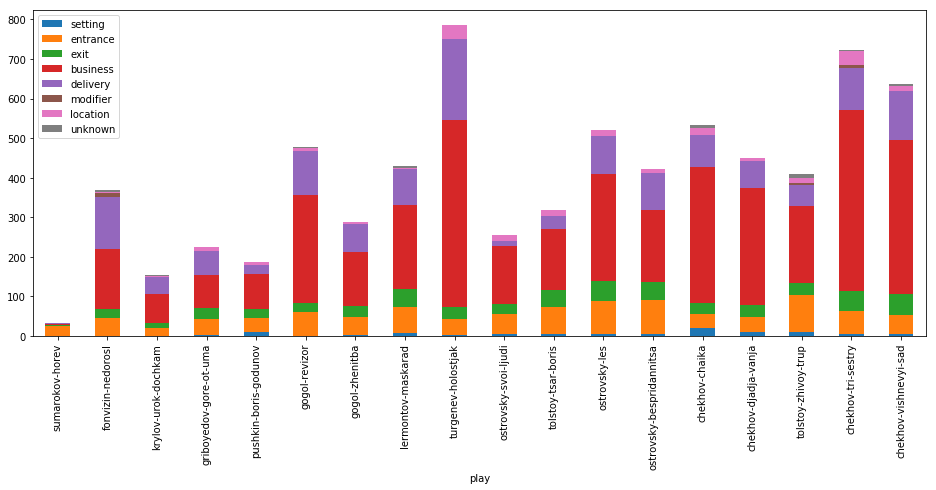

In [99]:
df_types[direction_types].plot.bar(stacked=True, figsize=(16,6))